In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import math
import scipy as sp
from scipy.interpolate import interp1d
from astropy.io import fits
from tqdm import tqdm

In [2]:
def weighted_fxn(w1, w2, f1, f2):
    """Computes the weighted combined function given two of the same kind of function
    for two different compositions."""
    weighted = (w1*f1 + w2*f2)/(w1+w2)
    return(weighted)

In [3]:
def scat_dihedral_angle(l_1,b_1,l_2,b_2):
    """Calculates the scattering and dihedral angle given an the coordinates pointing to the incoming radiation/
    and the coordinates to earth."""
    #defining meridian plane to be a vector in same plane but perpendicular 
    #to the scattered vector
    l_3 = l_2
    b_3 = b_2+90. #will guarantee there is a normal to meridional plane
    
    #adjusting l1, b1 coords to reflect the forward direction of incoming light
    #adjusting l2, b2 coords to change from earth's coord sys to dust particle's
    b1 = (b_1) * np.pi/180.
    l1 = (l_1+180.) * np.pi/180.
    b2 = (b_2) * np.pi/180.
    l2 = (l_2+180.) * np.pi/180.
    b3 = (b_3) * np.pi/180.
    l3 = (l_3+180.) * np.pi/180.

    #defining coordinates
    forward1 = np.cos(b1) * np.sin(l1)
    forward2 = np.cos(b1) * np.cos(l1)
    forward3 = np.sin(b1)
    scattered1 = np.cos(b2) * np.sin(l2)
    scattered2 = np.cos(b2) * np.cos(l2)
    scattered3 = np.sin(b2)
    meridian1 = np.cos(b3) * np.sin(l3)
    meridian2 = np.cos(b3) * np.cos(l3)
    meridian3 = np.sin(b3)
    
    #scat angle
    scat_angle = np.arccos((forward1 * scattered1) + 
                           (forward2 * scattered2) + 
                           (forward3 * scattered3))
    #forward or back scattering:
    if np.sin(scat_angle) < 1e-8:
        print("Forward or back scattering")
        scat_angle = 999
        dihedral_angle = 999
        return scat_angle, dihedral_angle
    
    #
    if l_1 == 135 or l_1 == 315 or l_1 == 495:
#         print("flag")
        dihedral_angle = 180.
        return scat_angle*180./np.pi, dihedral_angle
    
#     if (forward1*meridian1 + forward2*meridian2 + forward3*meridian3) \
#         /np.sin(scat_angle) < -1 or (forward1*meridian1 + forward2*meridian2 
#                              + forward3*meridian3) /np.sin(scat_angle) > 1:
#         print("out of domain", (forward1*meridian1 + forward2*meridian2 
#                              + forward3*meridian3) /np.sin(scat_angle), np.sin(scat_angle))
    
    #arccos argument > 1, set to be arccos(1):
    if (forward1*meridian1 + forward2*meridian2 
        + forward3*meridian3) /np.sin(scat_angle) > 1:
        dihedral_angle = 0.
        return scat_angle*180./np.pi, dihedral_angle

    if (forward1*meridian1 + forward2*meridian2 + forward3*meridian3) \
        /np.sin(scat_angle) < -1:
        dihedral_angle = 180.
        return scat_angle*180./np.pi, dihedral_angle
    
        
#     if np.sin(scat_angle) == 0:
#         print('div by zero')
# #     elif np.sin(scat_angle) > -1e8 and np.sin(scat_angle) < 1e8:
# #             print('div by almost zero')
    #dihedral angle
    dihedral_angle = np.arccos((forward1*meridian1 + forward2*meridian2 
                             + forward3*meridian3) /np.sin(scat_angle))
    return scat_angle *180./np.pi, dihedral_angle*180./np.pi

In [4]:
def Q(angle_array, weighted_Q, interp_type, l1, b1, l2, b2,): 
    interpolation = interp1d(angle_array, weighted_Q, kind=interp_type) #linear by default
    return(interpolation(scat_dihedral_angle(l1, b1, l2, b2)[0]))

In [5]:
rayleigh_I = np.loadtxt("rayleigh_phase.txt")
rayleigh_Q = np.loadtxt("rayleigh_pol.txt")

In [6]:
def rayleigh(angle_array, interp_type, l1, b1, l2, b2,):
    "interpolating the pol. phase fxn and phase fxn for the Rayleigh regime."
#these are now defined globally above ^
#     rayleigh_I = np.loadtxt("rayleigh_phase.txt")
#     rayleigh_Q = np.loadtxt("rayleigh_pol.txt")
    interpolation_I = interp1d(angle_array, rayleigh_I, kind=interp_type) #linear by default
    interpolation_Q = interp1d(angle_array, rayleigh_Q, kind=interp_type)
    return interpolation_I(scat_dihedral_angle(l1, b1, l2, b2)[0]), interpolation_Q(scat_dihedral_angle(l1, b1, l2, b2)[0])

In [7]:
def rot_matrix(angle_array, weighted_Q, interp_type, intensity, l1,b1,l2,b2, rayleigh = False):
    """Performs the general matrix multiplication that rotates the scattered [Q,U] \
    vector to be relative to 'true north'.
    """
    #Raleigh regime:
    if rayleigh ==True:
        Q_scat = rayleigh(angle_array, interp_type, l1,b1,l2,b2)[1] * intensity
    else:
        Q_scat = Q(angle_array, weighted_Q, interp_type, l1,b1,l2,b2) * intensity
    theta = scat_dihedral_angle(l1,b1,l2,b2)[1]
    U = 0.
    c, s = np.cos(2.*np.radians(theta)), np.sin(2.*np.radians(theta))
    R = np.array(((c, s), (s, c)))
    P = np.array((Q_scat, U))
    P_vector = np.transpose(P)
    product = np.matmul(R,P_vector)
    return product

In [8]:
def skyfilt(ifilt, z):
    """Reading in the array of intensity given an energy and height."""
    #heights = ['0', '0.1', '0.2', '0.5', '1', '2', '5', '10', '20', '30']
    
    with fits.open('/fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_'
                   + str(z) + '_Filter_HP.fits.gz') as hdul:
#         print(hdul.info())
        skymap = hdul[1].data
        skymap_header = hdul[1].header
        energies = hdul[2].data
        skyfilt = skymap['spectra'][:,ifilt]
        return skyfilt #, energies

In [9]:
for pixel in range(0,12288):
    pix2ang = hp.pix2ang(32, pixel, nest=False, lonlat=True)
    b1 = pix2ang[1]
    if b1 > 90 or b1 < -90:
        print(l1)
#this verifies that all latitudes are in [-90,90]

In [10]:
def sandage_integrator(tmax, nside):
    #takes tmax measured from south pole
    total_pix = hp.nside2npix(nside)
    cos_thetas = np.full(total_pix, 1e-24, dtype = float)
    
    for pixel in tqdm(range(0,total_pix)):
        pix2ang = hp.pix2ang(nside, pixel, nest=False, lonlat=True)
        b1 = pix2ang[1]
      
        if b1 < (tmax - 90):
            theta = 90 + b1
            cos_thetas[pixel] = (1/ np.cos(np.pi/180. * theta))
     
    integral = -2 * np.pi * np.log(np.cos((tmax) * np.pi/180.)) #analytical integral needs 2pi to give 4pi
    df_integrated_all = 4 * np.pi * sum(cos_thetas)/total_pix 

    print('\n integral,', integral, 
          '\n df cos integrated over all pixels,', df_integrated_all,
          '\n difference,', integral - df_integrated_all)

    return cos_thetas, sum(cos_thetas)/total_pix, integral

In [11]:
#driver program:
def whole_sky(model, z, ifilt, nside, tmax, l2, b2, stmax, par_trans_rot = 1.294539149243122,
              anisotropic = True, info = True, mollview = False, smooth = False,\
              rayleigh = False, mezger = False, sandage = False, sandage_90 = False, sandage_0 = False,\
              galactic_centre = False, g = False, trig_check = False, sandage_rayleigh = False,
              start = 0, end = True, interp_type = 'linear'):
    """
    Prints the polarization and other parameters for a dust particle of a given /
    model, and a height z with a specified intensity.
    
    Default: runs frankie files, assumes anisotropic, no rayleigh scattering, no sandage disk model, not 
    just lit from the galactic centre.
    
    Parameters:
    model (int) : dust model is being used
    z (float) : height of dust particle out of galactic plane
    ifilt (array_like) : intensities corresponding to an energy
    aniso_check (Bool) : False overwrites the intensity from file for isotropic rad. field
    
    """
    total_pix = hp.nside2npix(nside)
    if end == True:
        end = total_pix

    #for vectors
    Q_sky = np.full(total_pix, 0, dtype = float)
    U_sky = np.full(total_pix, 0, dtype = float)
    I_sky = np.full(total_pix, 0, dtype = float)
    I_phase_fxn = np.full(total_pix, 0, dtype = float)
    
    if g == True:
        c_sky = np.full(total_pix, 0, dtype = float)
        g_array = np.full(total_pix, 0, dtype = float)

    if trig_check == True:
        cos = np.full(total_pix, 0, dtype = float)
        sin = np.full(total_pix, 0, dtype = float)
        theta = np.full(total_pix, 0, dtype = float)
    
    if sandage == True:
        ### difference here (1e-24)
        cos_thetas = np.full(total_pix, 10e-24, dtype = float)
    
    #loading and identifying model
    angle_array = np.loadtxt("angle_array.txt")
    weighted_Q = np.loadtxt("weighted_Q_"+str(model)+".txt")
    weighted_phase_fxn = np.loadtxt("weighted_phase_fxn_"+str(model)+".txt")
    I_interpolation = interp1d(angle_array, weighted_phase_fxn, kind=interp_type)
    
    if info == True:
        if model == 0:
            print('Model 0, r band. \n Compeigne; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 1:
            print('Model 1, g band. \n Compeigne; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 2:
            print('Model 2, r band. \n Weingartner and Draine rv 3.1; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 3:
            print('Model 3, g band. \n Weingartner and Draine rv 3.1; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 4:
            print('Model 4, r band. \n Weingartner and Draine rv 5.5; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 5:
            print('Model 5, g band. \n Weingartner and Draine rv 5.5; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 6:
            print('Model 6, r band. \n Astrodust w New size dist')
        if model == 7:
            print('Model 7, g band. \n Astrodust w New size dist')
        if model == 8:
            print('Model 8, r band. \n Astrodust w Weingartner Sil size dist')
        if model == 9:
            print('Model 9, g band. \n Astrodust w Weingartner Sil size dist')
        if model == 10:
            print('Model 10, r band. \n Astrodust w Compeigne Sil size dist')
        if model == 11:
            print('Model 11, g band. \n Astrodust w Compeigne Sil size dist')
     #isotropic or anisotropic
    if anisotropic == True:
        intensity_array = skyfilt(ifilt, z)
#     else:
#         intensity_array = np.ones(total_pix, dtype = float)
    
    #for Rayleigh:
    if rayleigh == True:
#         print('Rayleigh regime')
        I_interpolation = interp1d(angle_array, rayleigh_I, kind=interp_type)

        
    # SANDAGE 90
    if sandage_90 == True:
        intensity_array = np.full(total_pix, 0, dtype = float)
        b1 = 0
        l1 = 0
        for i in range(0,3600):
            l1 += 0.1
            equatorpix = hp.ang2pix(nside, l1, b1, lonlat = True)
        #                 intensity = intensity_array[equatorpix]
            intensity_array[equatorpix] = 1
      
    #############################################
    
    if mezger == True:
        print('setting up the uniform disk with extinction model')
        scaleh = 130                 # pc 
        kv = 1.23          # how much tau per kpc in the uniform disk 
#         kv = 1.  #how much tau per kpc in the uniform disk 
        tauvscaleh = kv * scaleh/1000. 
#         tauvscaleh = 0.19086211 #g
        tauvscaleh = 0.13901505 #r
        # ; sensitivity to changing this is small 
        # ;tauvscaleh = 2. * tauvscaleh 
        # ;tauvscaleh = 0.5 * tauvscaleh 

        print('scaleh, kv, tauvscaleh ', scaleh, kv, tauvscaleh)

        print('nside uniform disk ', nside)
        total_pix = hp.nside2npix(nside) 
        rows = 1.0*total_pix 
        print('expected nside, rows ', nside, total_pix)
        illum = np.full(total_pix, 0, dtype = float) 

    #     ; enable the whole lower heisphere 
        stmaxh = 90.0 # lower hemisphere only, at most 
        stmaxhr = stmaxh*np.pi/180.
        stmaxinf = 89.99 # avoid infinity from 1/cos(str) 
        stmaxinfr = stmaxinf*np.pi/180. 

    #     ; confine to a cone  like in Sandage 
#         stmax = 90.0 #confine to a cone  like in Sandage 
#         stmax =70.0 # confine to a cone 
        stmaxr = stmax*np.pi/180. 
    
    ###########################################
    
#     for pixel in tqdm(range(start,end)):
    for pixel in range(start,end):
        pix2ang = hp.pix2ang(nside, pixel, nest=False, lonlat=True)
        #taking parallel transport rotation into account:
        l1 = pix2ang[0] #- par_trans_rot
        b1 = pix2ang[1]
           
        
    #intensity (Sandage)    
        if sandage == True:
            if b1 < (tmax - 90):
                theta = 90 + b1
                cos_thetas[pixel] = 4 * np.pi * (1/ np.cos(np.pi/180. * theta))/total_pix
                ## 2023 trial to match sandage integrator
                cos_thetas[pixel] = 1/ np.cos(np.pi/180. * theta)
            intensity = cos_thetas[pixel]
         
        ####################
        elif mezger == True:
#             b1 = 90.0 - pix2ang[1] 
            if b1 <= (stmax - 90):
#                 print('b1 check') # it enters this if statement
                strr = (np.pi/2) + (b1 *np.pi/180.) #converts measurement from equator to south
        #     ; entire lower hemisphere 
                if (strr > stmaxinfr and strr <= stmaxhr):
                    illum[pixel] = 1.0 # avoids infinity in exp(-2.d0*tauvscaleh*infinity) 
#                     print('check1')
                elif (strr <= stmaxinfr):
                    illum[pixel] = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(strr)) # mezger 1982, Equation C1 
#                     print('check2')
            intensity = illum[pixel]
        
        
        ####################
        
        # SANDAGE 90 or 0
        elif sandage_90 == True:
            intensity = intensity_array[pixel]
        elif sandage_0 == True:
            if pixel == hp.ang2pix(nside, 0, -90, lonlat = True): 
                intensity = 1
            else:
                intensity = 0

                
    #intensity (gal centre):
        elif galactic_centre == True:
            if pixel == hp.ang2pix(nside, 0, 0, lonlat = True): 
                intensity = intensity_array[pixel]
            else:
                intensity = 0
        else:
            intensity = intensity_array[pixel]
        
        scat_angle = scat_dihedral_angle(l1, b1, l2, b2)[0]
        rotation = rot_matrix(angle_array, weighted_Q, interp_type, intensity, l1,b1,l2,b2)
        
        #making vectors
        Q_sky[pixel] = rotation[0]
        U_sky[pixel] = rotation[1]
        
        I = I_interpolation(scat_angle)
        I_phase_fxn[pixel] = I
        I_sky[pixel] = (I * intensity)
        
        if g == True:
            c_sky[pixel] = (np.cos((np.pi/180.)*scat_angle) * I)
        
        if trig_check == True:
            cos[pixel] = (np.cos((np.pi/180.)*scat_angle))
            sin[pixel] = (np.sin((np.pi/180.)*scat_angle))
            theta[pixel] = scat_angle
        
    #totals
    Q_sky_t = sum(Q_sky)
    U_sky_t = sum(U_sky)
    I_sky_t = sum(I_sky)
    I_phase_t = sum(I_phase_fxn)
   
    #polarization and pol. angle
    pol_angle = (0.5*(math.atan2(U_sky_t,Q_sky_t))*180./np.pi)
    P_sky = ((Q_sky_t**2. + U_sky_t**2.)**0.5)

    ##########################
    
    if mezger == True:
        #     ; numerical integral 
        tot_unifi = sum(illum)/rows *2.0 
        med_unifi = np.median(illum)*2.0 
    #     ; analytical 
        ttau = 2.0*tauvscaleh 
        e1 = sp.special.exp1(ttau) 
        an_unifi = (1.0 -  ttau*(np.exp(-ttau)/ttau - e1)) # mezger 1982, Equation C2, C3 
        print('average tunifi, aunifi; median ',  tot_unifi, an_unifi, med_unifi) 
    #     ; what angle creates this? 
        stratav = np.arccos(-ttau/np.log(1.0 - an_unifi)) * 180./np.pi
        iatav = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(stratav*np.pi/180.)) 
        print('stratav , iatav ', stratav , iatav)
        thetaatav = 180.0 - stratav 
        batav = 90.0 - thetaatav 
        print('theta at av, b at av ', thetaatav, batav)

        iunifmin = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(0.)) 
        iunifmax = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(stmaxr)) 

        print('stmax, stmaxr ', stmax, stmaxr)
        print('iunifmin, iunifmax', iunifmin, iunifmax)
    
    ##############################
    
    if info == True:
        print('Q_sky:', "{:.7E}".format(Q_sky_t), 
              '\n U_sky:', "{:.7E}".format(U_sky_t), 
              '\n I_sky:', "{:.7E}".format(I_sky_t), 
              '\n P_sky:', "{:.7E}".format(P_sky), 
              '\n P_sky/I_sky (pol frac):',"{:.7E}".format(P_sky/I_sky_t), 
              '\n Integral of phase fxn I:', "{:.7E}".format(I_phase_t/end), 
              '\n Pol. angle:', pol_angle,
              '\n average illlum', sum(intensity_array)/total_pix)

    if sandage or rayleigh== True:
#         cos_integrated = sum(cos_thetas)
        return pol_angle, P_sky, P_sky/I_sky_t, Q_sky_t, U_sky_t, I_sky_t, cos_thetas, sum(cos_thetas)

        # SANDAGE
    if sandage_90 == True or sandage_0 == True:
        return pol_angle, P_sky, P_sky/I_sky_t, Q_sky_t, U_sky_t, I_sky_t
    
    if g == True:
        g = sum(c_sky)/(I_phase_t)
#         cos = 4 * np.pi * sum(cos_thetas)/total_pix
        print('g:', g)
#               '\n cos array:', cos)
    if trig_check == True:
        cos_t = sum(cos)/end
        sin_t = sum(sin)/end
        theta_t = sum(theta)
        print('avg cos:', cos_t, 
              '\n avg sin:', sin_t)
#         return cos, sin, theta
        
    if mollview == True:
        return Q_sky, U_sky, I_sky, pol_angle, P_sky/I_sky_t, illum
    return pol_angle, P_sky, P_sky/I_sky_t, Q_sky_t, U_sky_t, I_sky_t, #sum(illum)

In [15]:
sand = whole_sky(0, 0.2, 3, 256, 89, 135., 40., 90, sandage=True)[6]
print(sand, sand[6080], sand[10187])
sortedsand = np.sort(sand)
print(sortedsand)

Model 0, r band. 
 Compeigne; Draine silicate, Zubko amorphous carbon. 
 Height: 0.2 kpc. 
Q_sky: 1.5119759E+04 
 U_sky: 7.9195329E+04 
 I_sky: 9.4897386E+05 
 P_sky: 8.0625723E+04 
 P_sky/I_sky (pol frac): 8.4960952E-02 
 Integral of phase fxn I: 1.0000680E+00 
 Pol. angle: 39.59565755169593
[1.00000000e-23 1.00000000e-23 1.00000000e-23 ... 1.00000509e+00
 1.00000509e+00 1.00000509e+00] 1e-23 1e-23
[1.00000000e-23 1.00000000e-23 1.00000000e-23 ... 5.48571429e+01
 5.48571429e+01 5.48571429e+01]


In [18]:
f = open('udiemoll.txt', "w")
for value in udie:
    f.write(str(value)) 
    f.write("\n")
f.close()

In [16]:
udie = whole_sky(0, 0.2, 3, 256, 0, 135., 40., 90, mezger=True, mollview=True)[5]
print(udie, udie[6080])
sortedudie = np.sort(udie)
print(sortedudie)
print(sortedudie[6080],sortedudie[12287])

Model 0, r band. 
 Compeigne; Draine silicate, Zubko amorphous carbon. 
 Height: 0.2 kpc. 
setting up the uniform disk with extinction model
scaleh, kv, tauvscaleh  130 1.23 0.13901505
nside uniform disk  256
expected nside, rows  256 786432
average tunifi, aunifi; median  0.5116736947092301 0.5103715280607795 0.4860008551180601
stratav , iatav  67.08663665574038 0.5103715280607795
theta at av, b at av  112.91336334425962 -22.913363344259622
stmax, stmaxr  90 1.5707963267948966
iunifmin, iunifmax 0.2427259727769362 1.0
Q_sky: -1.8308528E+02 
 U_sky: 9.6045635E+03 
 I_sky: 1.0217930E+05 
 P_sky: 9.6063083E+03 
 P_sky/I_sky (pol frac): 9.4014228E-02 
 Integral of phase fxn I: 1.0000680E+00 
 Pol. angle: 45.54602915247869
[0.         0.         0.         ... 0.24272704 0.24272704 0.24272704] 0.0
[0. 0. 0. ... 1. 1. 1.]
0.0 0.0


In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
udie = np.loadtxt("udiemoll.txt")
sand = np.loadtxt("sandmoll.txt")

0.0 180.0 -180.0 180.0


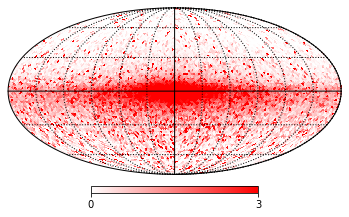

In [14]:
# fig, axs = plt.subplots(2, 1)
corrected_skyfilt = np.where(skyfilt(3, 0.2) == 0, 10e-5, skyfilt(3,0.2))
col_map = colors.LinearSegmentedColormap.from_list('',["white","red"])
hp.mollview(skyfilt(3, 0.2)/724252470.8195218, cmap = col_map, max = 3, norm = 'linear', title=None, hold=True)
hp.graticule()

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()
plt.savefig("./plots/rfrankie3.pdf", dpi = 600)

In [16]:
def mollview(ifilt, z, norm_type = 'linear', col_map = 'jet'):
    corrected_skyfilt = np.where(skyfilt(ifilt, z) == 0, 10e-5, skyfilt(ifilt, z))
    col_map = colors.LinearSegmentedColormap.from_list('',["white","red"])
#     sky = hp.mollview(corrected_skyfilt, norm = norm_type, min=1e6, cbar = None, cmap = col_map, title = None)
    hp.mollview(skyfilt(ifilt, z), norm = norm_type, cmap = col_map, title=None)
    hp.graticule()
    
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
#     cmap = fig.colorbar(image, ax=ax, )
#     plt.yticks()
#     cmap.ax.yaxis.set_tick_params('major')

0.0 180.0 -180.0 180.0


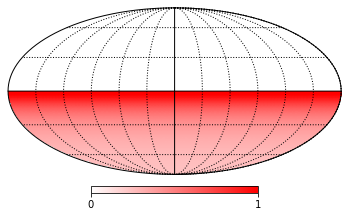

In [22]:
col_map = colors.LinearSegmentedColormap.from_list("", ["white","red"])
# col_map = 'jet'

#0.3173
hp.mollview(udie, cmap=col_map, min = 0., max = 1, title=None, hold=True)
hp.graticule()
plt.savefig("./plots/rusie.pdf", dpi = 600)

0.0 180.0 -180.0 180.0


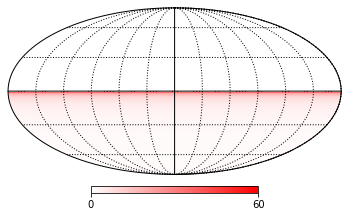

In [23]:
hp.mollview(sand, cmap=col_map, min = 0, max = 60, title=None, hold=True)
hp.graticule()
plt.savefig("./plots/rsand.pdf", dpi = 600)

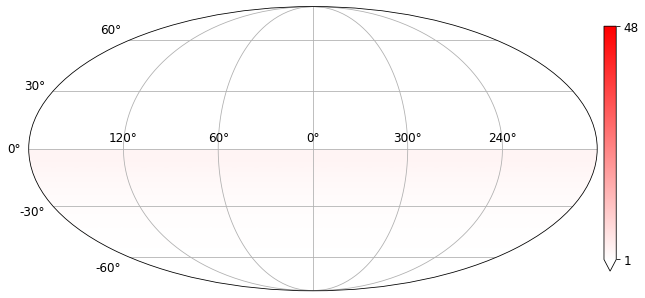

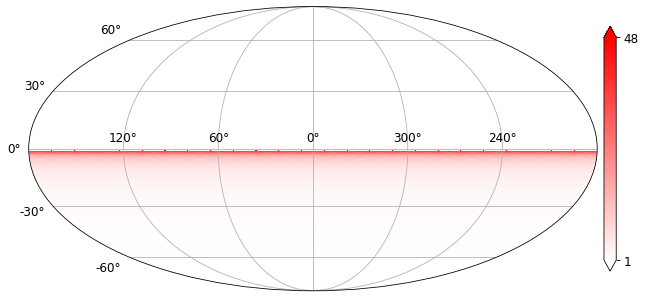

In [66]:
col_map = colors.LinearSegmentedColormap.from_list("", ["white","red"])
hp.projview(udie/0.3173, cmap=col_map, min = 1, max = 48, title=None, cb_orientation="vertical",
            graticule=True,
    graticule_labels=True,projection_type="mollweide")
# plt.savefig("./plots/rusie.pdf", dpi = 600)

# fig = plt.gcf()
# ax = plt.gca()
# image = ax.get_images()[0]
# cbar = fig.colorbar(image, ax=ax1)


# sand = whole_sky(0, 0.2, 3, 32, 89, 135., 40., 90, sandage=True)[6]
# hp.mollview(sand, cmap=col_map, min = 1, max = 4.2, title=None)

hp.projview(sand, cmap=col_map, min = 1, max = 48, projection_type="mollweide", 
            graticule=True,
    graticule_labels=True,cb_orientation="vertical",title=None)
hp.graticule()
# plt.savefig("./plots/rusiesand.pdf", dpi = 600)

In [69]:
sortedudie = np.sort(udie/0.3173)
print(sortedudie)
print(sortedudie[6080],sortedudie[12287])

[0.         0.         0.         ... 3.15159155 3.15159155 3.15159155]
0.0 0.0


In [38]:
sand = sandage_integrator(89, 32)[0]
sortsand = np.sort(sand)
print(sortsand[0], sortsand[12287])
print(sand, sortsand)

100%|██████████████████████████████████| 12288/12288 [00:00<00:00, 48823.14it/s]


 integral, 25.436079184727838 
 df cos integrated over all pixels, 27.95039662635389 
 difference, -2.5143174416260514
1e-24 47.999999999999616
[1.00000000e-24 1.00000000e-24 1.00000000e-24 ... 1.00032563e+00
 1.00032563e+00 1.00032563e+00] [1.0e-24 1.0e-24 1.0e-24 ... 4.8e+01 4.8e+01 4.8e+01]


100%|██████████████████████████████████| 12288/12288 [00:00<00:00, 48086.69it/s]
0.0 180.0 -180.0 180.0



 integral, 25.436079184727838 
 df cos integrated over all pixels, 27.95039662635389 
 difference, -2.5143174416260514


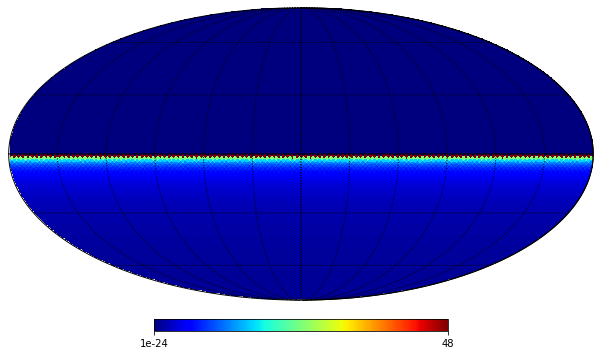

In [75]:
col_map = colors.LinearSegmentedColormap.from_list("", ["white","red"])
col_map = 'jet'
# cos_map = whole_sky(0, 0.2, 3, 32, 89, 135., 40., 90, sandage=True, mollview=True)
# cos_map = sandage_integrator(89, 32)[0]
cos_map = sandage_integrator(89, 32)[0]
# cos_map = whole_sky(0, 0.2, 3, 32, 89, 135., 40., 90, sandage=True, mollview=True)

# hp.mollview(cos_map, norm = 'linear', cmap = col_map, rot = (180,0,0), min = 10e-5, max = 0.5 * 1/np.cos((np.pi/180.)*40), title=None)
hp.mollview(cos_map, norm = 'linear', cmap = col_map, rot = (180,0,0), title=None)

hp.graticule()
# hp.mollview(corrected_skyfilt, norm = norm_type, cmap = col_map, unit = 'MeV')

Model 1, g band. 
 Compeigne; Draine silicate, Zubko amorphous carbon. 
 Height: 0.2 kpc. 


0.0 180.0 -180.0 180.0


Q_sky: 4.4626540E+10 
 U_sky: 8.2335375E+10 
 I_sky: 2.9757292E+12 
 P_sky: 9.3651706E+10 
 P_sky/I_sky (pol frac): 3.1471851E-02 
 Integral of phase fxn I: 1.0001087E+00 
 Pol. angle: 30.770947322187087


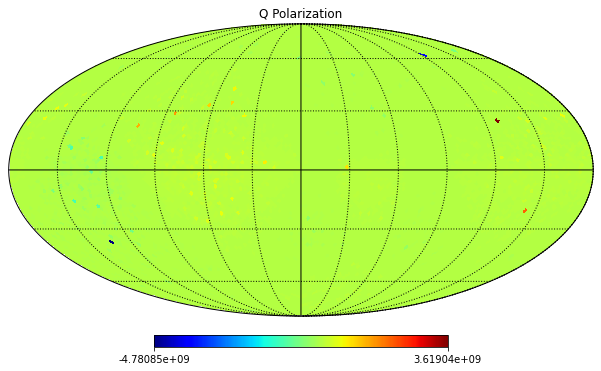

In [118]:
hp.mollview(whole_sky(1, 0.2, 1, 32, 0, mollview =True)[0], norm = 'linear', cmap = 'jet', \
            title='Q Polarization')
hp.graticule()

Model 1, g band. 
 Compeigne; Draine silicate, Zubko amorphous carbon. 
 Height: 0.2 kpc. 


0.0 180.0 -180.0 180.0


Q_sky: 1.1381223E+11 
 U_sky: 9.5208186E+10 
 I_sky: 2.2984090E+13 
 P_sky: 1.4838404E+11 
 P_sky/I_sky (pol frac): 6.4559456E-03 
 Integral of phase fxn I: 1.0001087E+00 
 Pol. angle: 19.95687130529894


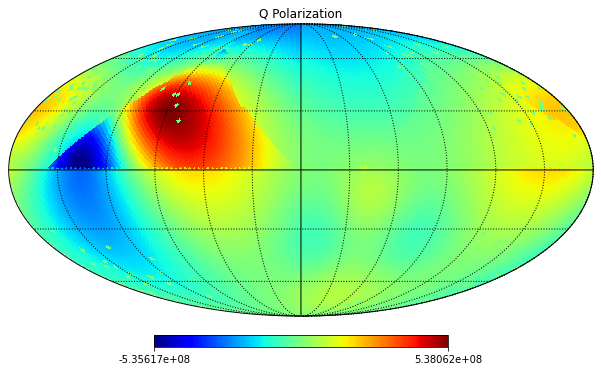

In [133]:
hp.mollview(whole_sky(1, 0.2, 1, 32, 0, 1e8, mollview = True, smooth = True)[0], norm = 'linear', cmap = 'jet', \
            title='Q Polarization')
hp.graticule()

In [117]:
hp.mollview(whole_sky(1, 0.2, 1, 32, 0, 135., 40., mollview =True)[2], norm = 'log', cmap = 'jet', \
            title='I scattered')

Model 1, g band. 
 Compeigne; Draine silicate, Zubko amorphous carbon. 
 Height: 0.2 kpc. 
Q_sky: 4.4626540E+10 
 U_sky: 8.2335375E+10 
 I_sky: 2.9757292E+12 
 P_sky: 9.3651706E+10 
 P_sky/I_sky (pol frac): 3.1471851E-02 
 Integral of phase fxn I: 1.0001087E+00 
 Pol. angle: 30.770947322187087


ValueError: values must all be positive

ValueError: values must all be positive

<Figure size 612x388.8 with 1 Axes>

In [195]:
def mollview(ifilt, z, norm_type = 'linear', col_map = 'jet'):
    corrected_skyfilt = np.where(skyfilt(ifilt, z) == 0, 10e-5, skyfilt(ifilt, z))

    sky = hp.mollview(corrected_skyfilt, norm = norm_type, min = 1e6, cbar = None, cmap = col_map, unit = 'J/sr')
#     hp.mollview(skyfilt(ifilt, z), norm = norm_type, cmap = col_map, unit = 'MeV')
    hp.graticule()
    
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cmap = fig.colorbar(image, ax=ax, )
#     plt.yticks()
#     cmap.ax.yaxis.set_tick_params('major')

Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 BinTableHDU     11   28R x 1C   [D]   
None
Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 BinTableHDU     11   28R x 1C   [D]   
None


0.0 180.0 -180.0 180.0


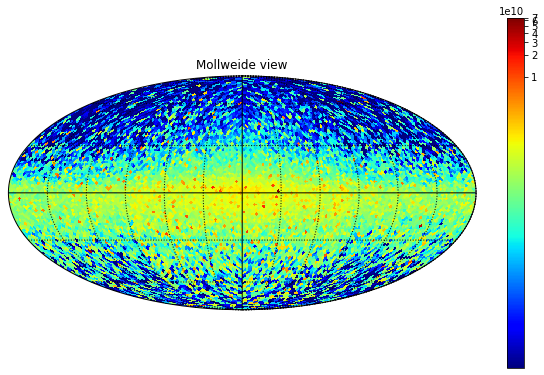

In [196]:
mollview(1, 0.2, norm_type = 'log')

In [200]:
def projview(ifilt, z):
    corrected_skyfilt = np.where(skyfilt(ifilt, z) == 0, 10e-5, skyfilt(ifilt, z))
    hp.projview(corrected_skyfilt, graticule=True,
    graticule_labels=True,
    unit="cbar label",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="vertical")

Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 BinTableHDU     11   28R x 1C   [D]   
None
Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 BinTableHDU     11   28R x 1C   [D]   
None


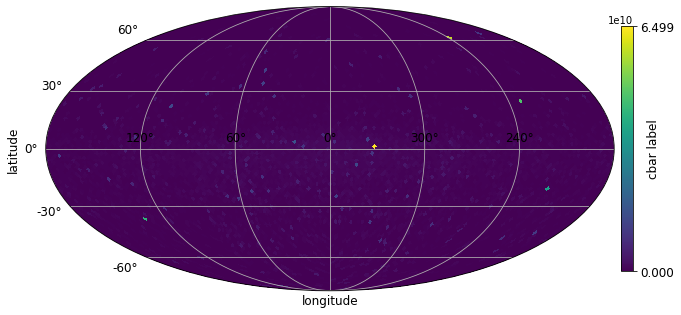

In [201]:
projview(1,0.2)

In [91]:
def map_smoother(ifilt, z, nside, max_value, norm_type = 'linear', col_map = 'jet'):
    total_pix = hp.nside2npix(nside)
    smoothed_skyfilt = skyfilt(ifilt, z)
    for pixel in range(0,total_pix):
        if smoothed_skyfilt[pixel] > max_value:
            oldpix = hp.pix2ang(nside, pixel, lonlat = True)

            newpix = hp.ang2pix(nside, (np.pi/180.)*oldpix[0], (np.pi/180.)*(oldpix[1] + 2))
            smoothed_skyfilt[pixel] = smoothed_skyfilt[newpix]
    hp.mollview(smoothed_skyfilt, norm = norm_type, cmap = col_map, unit = 'MeV', cbar = None)
    fig = plt.gcf() # get figure
    ax = plt.gca() # get axis
    image = ax.get_images()[0] #gets images which are attached to the axes
    fig.colorbar(image, ax=ax)
    hp.graticule()
    return smoothed_skyfilt

In [75]:
def orthview(ifilt, z, norm_type, cmap_type, lon, lat):
    corrected_skyfilt = np.where(skyfilt(ifilt, z) == 0, , skyfilt(ifilt, z))
    hp.orthview(corrected_skyfilt, norm = norm_type, cmap = cmap_type, rot = (lon, lat, 0), unit = 'MeV')
    hp.graticule()

0.0 180.0 -180.0 180.0


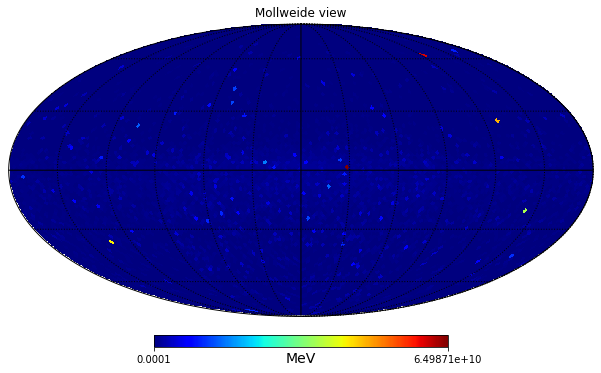

In [103]:
mollview(1, 0.2, 'linear', 'jet')

0.0 180.0 -180.0 180.0


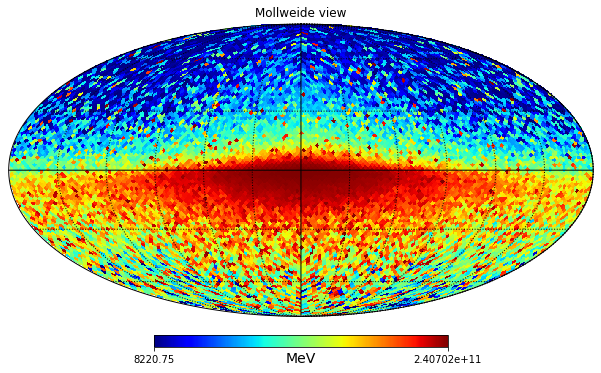

In [117]:
mollview(3, 0.5, 'hist', 'jet')

0.0 180.0 -180.0 180.0


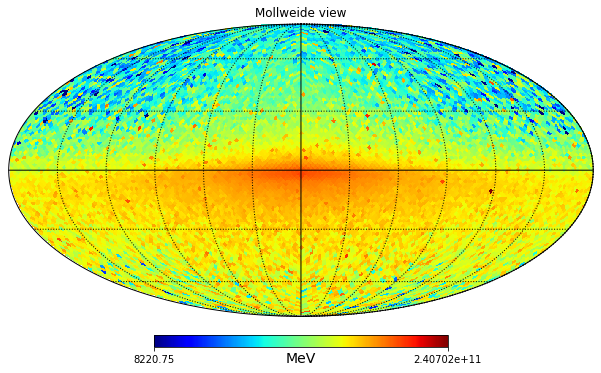

In [116]:
mollview(3, 0.5, 'log', 'jet')
#force going from 10^4 to 10^10

Model 1, g band. 
 Compeigne; Draine silicate, Zubko amorphous carbon. 
 Height: 0.2 kpc. 


0.0 180.0 -180.0 180.0


Q_sky: 4.4571531E+10 
 U_sky: 8.2950382E+10 
 I_sky: 2.9830521E+12 
 P_sky: 9.4166805E+10 
 P_sky/I_sky (pol frac): 3.1567268E-02 
 Integral of phase fxn I: 1.0001110E+00 
 Pol. angle: 30.87481710700392


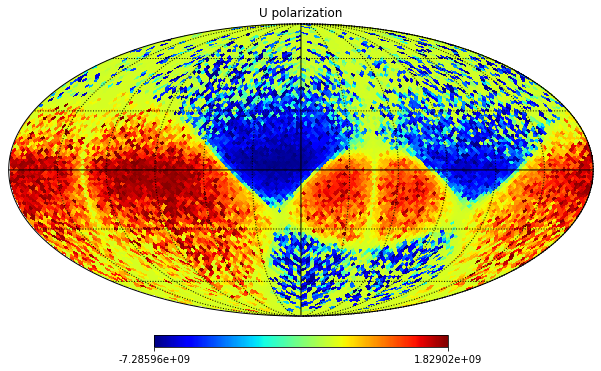

In [304]:
hp.mollview(whole_sky(1, 0.2, 1, 32, 0, mollview =True)[1], norm = 'hist', cmap = 'jet', \
            title='U polarization')
hp.graticule()

In [135]:
 def mollview_plotter(model, ifilt):
    corrected_whole_sky = np.where(whole_sky(model, 0.2, ifilt, 32, 0, 135., 40.,mollview =True, info = False) == 0, 10e-5, whole_sky(model, 0.2, ifilt, 32, 0, 135., 40.,mollview =True, info = False))
    for i in range(0,5): 
        if i == 0:
            pol = 'Q sky'
        if i == 1:
            pol = 'U sky'
        if i == 2:
            pol = 'I sky'
#         if i == 3:
#             pol = 'Polarization Angle'
#         if i == 4:
#             pol = 'Polarization Fraction'
        hp.mollview(whole_sky(model, 0.2, ifilt, 32, 0, 135., 40.,mollview =True, info = False)[i], norm = 'log', cmap = 'jet', \
                title=pol)
    hp.graticule()

In [136]:
mollview_plotter(6,3)

Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 BinTableHDU     11   28R x 1C   [D]   
None
Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 BinTableHDU     11   28R x 1C   [D]   
None
Filename: /fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_0.2_Filter_HP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   12288R x 1C   [28D]   
  2  ENERGIES      1 

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


None


ValueError: values must all be positive

ValueError: values must all be positive

<Figure size 612x388.8 with 2 Axes>

0.0 180.0 -180.0 180.0


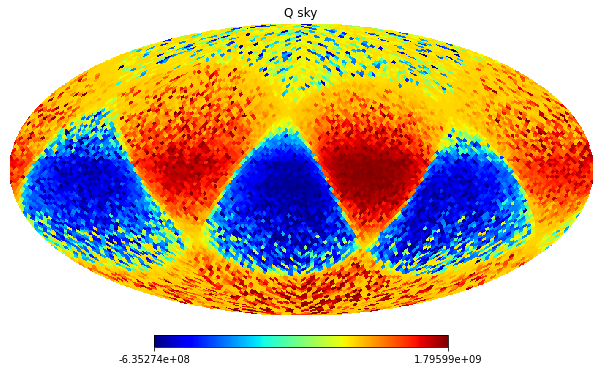

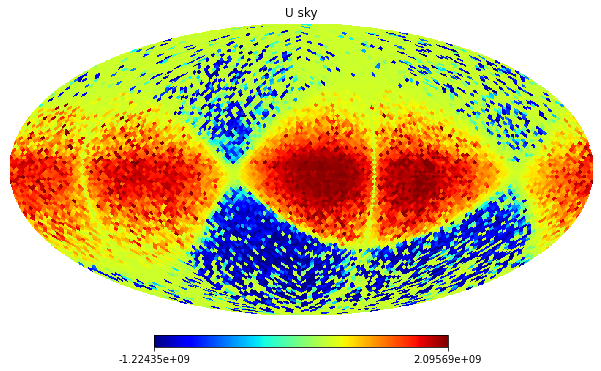

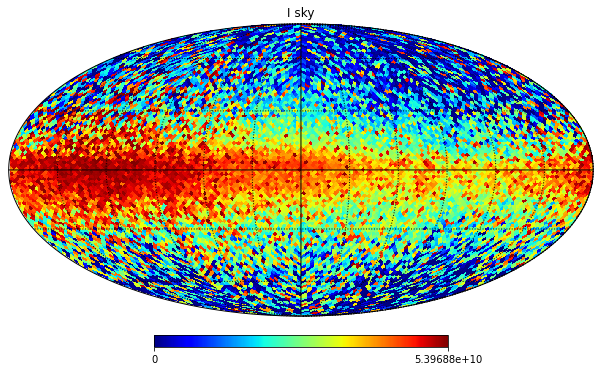

In [348]:
mollview_plotter(7,1)

100%|███████████████████████████████████████████████████████████████| 12288/12288 [00:02<00:00, 4292.58it/s]
0.0 180.0 -180.0 180.0


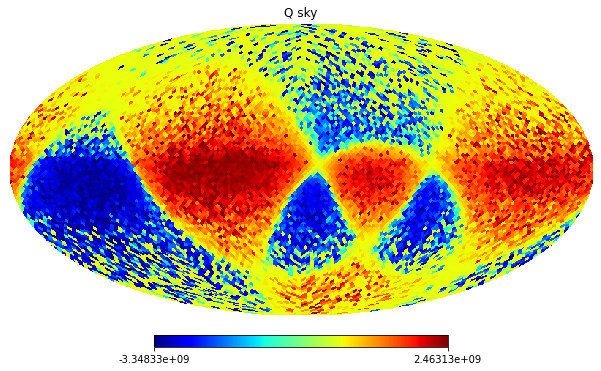

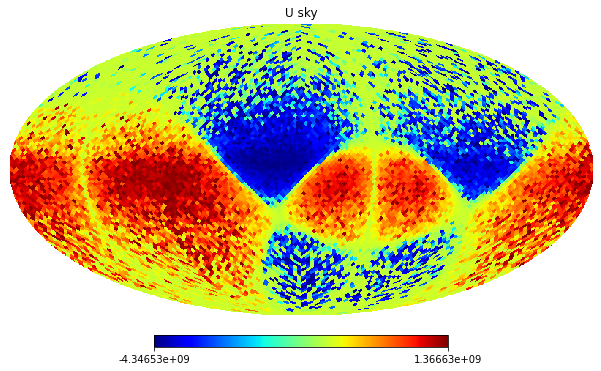

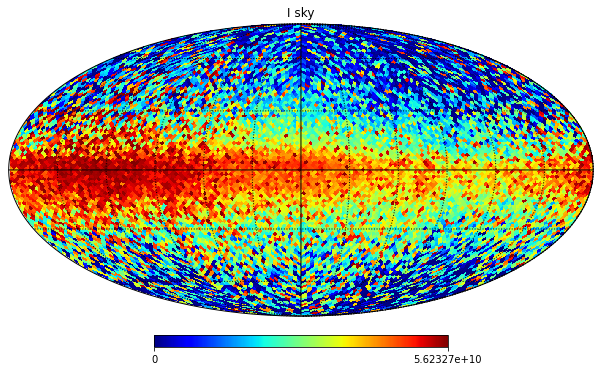

In [320]:
mollview_plotter(7,1)